# Load the pred_T file and the gold file

In [1]:
# pred_file = 'analysis/predT_not_in_original_pmid_predTs.json'
gold_file = 'data/KD-DTI/raw/test.json'
pmid = 'data/KD-DTI/raw/relis_test.pmid'
interactions_file = 'data/KD-DTI/raw/interactions'

In [2]:
import json

# load the gold standard
with open (gold_file, 'r') as f:
    gold_d = json.load(f)

print(len(gold_d))

# load the pmid
pmids = []
with open (pmid, 'r') as f:
    for line in f:
        line = line.rstrip()
        pmids.append(line)

print(len(pmids))

1159
1159


# Load the model

In [3]:
import torch
from src.transformer_lm_prompt import TransformerLanguageModelPrompt
m = TransformerLanguageModelPrompt.from_pretrained(
        "checkpoints/RE-DTI-BioGPT", 
        "checkpoint_avg.pt", 
        "data/KD-DTI/relis-bin",
        tokenizer='moses', 
        bpe='fastbpe', 
        bpe_codes="data/bpecodes",
        max_len_b=1024,
        beam=5)
m.cuda()

2023-05-08 00:28:14 | INFO | fairseq.file_utils | loading archive file checkpoints/RE-DTI-BioGPT
2023-05-08 00:28:14 | INFO | fairseq.file_utils | loading archive file data/KD-DTI/relis-bin
2023-05-08 00:28:43 | INFO | src.language_modeling_prompt | dictionary: 42384 types
2023-05-08 00:28:46 | INFO | fairseq.models.fairseq_model | {'_name': None, 'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 100, 'log_format': None, 'tensorboard_logdir': None, 'wandb_project': None, 'azureml_logging': False, 'seed': 1, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': False, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'user_dir': '../../src', 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False, 'reset_logging': False

GeneratorHubInterface(
  (models): ModuleList(
    (0): TransformerLanguageModelPrompt(
      (decoder): TransformerDecoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(42393, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(1026, 1024, padding_idx=1)
        (layers): ModuleList(
          (0-23): 24 x TransformerDecoderLayerBase(
            (dropout_module): FairseqDropout()
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (activation_dropout_module): FairseqDropout()
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwis

In [4]:
# because it's hard to use the moses tokenizer.decode() to show the different between the 4 (= 4#) and 4</w>
# so here using the tokenizer from HF to decode each generated token, and it doesn't include the learn0 - learn9, which is not a problem
from transformers import BioGptTokenizer

tokenizer = BioGptTokenizer.from_pretrained("microsoft/biogpt")

/home/tian/mambaforge/envs/BioGPT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# inference step by step

In [5]:
# a test data: {"pmid": ,
#               "id": ,
#               "title+abstract.lower()": ,
#               "text_tokens": ,
#               "pred_Ts": ,
#              "pred_Ts_tokens": ,}
#               "gold_triples": ,}

def get_test_data(id):
    prefix = torch.arange(42384, 42393)
    test_data = {}
    test_data['pmid'] = pmids[id]
    test_data['text'] = gold_d[test_data['pmid']]['title'].strip() + " " + gold_d[test_data['pmid']]['abstract']
    test_data['text'] = test_data['text'].lower().strip().replace('  ', ' ')
    # no "2" in the end
    test_data['text_tokens'] = m.encode(test_data['text'])[:-1]
    test_data['text_tokens_with_prefix'] = torch.cat([test_data['text_tokens'], prefix], dim=-1).unsqueeze(0).cuda()
    test_data['gold_triples'] = gold_d[test_data['pmid']]['triples']
    return test_data

In [94]:
test_data = get_test_data(60)

print(test_data["gold_triples"])
# print(f'"gold": {test_data["gold_triples"][0]},')
print(f'"text": "{test_data["text"]}"\n')

[{'drug': 'PF-4957325-00', 'target': 'Phosphodiesterase 8 (PDE8)', 'interaction': 'inhibitor'}]
"text": "pde8 regulates rapid teff cell adhesion and proliferation independent of icer. background: abolishing the inhibitory signal of intracellular camp by phosphodiesterases (pdes) is a prerequisite for effector t (teff) cell function. while pde4 plays a prominent role, its control of camp levels in teff cells is not exclusive. t cell activation has been shown to induce pde8, a pde isoform with 40- to 100-fold greater affinity for camp than pde4. thus, we postulated that pde8 is an important regulator of teff cell functions. methodology/principal findings: we found that teff cells express pde8 in vivo. inhibition of pde8 by the pde inhibitor dipyridamole (dp) activates camp signaling and suppresses two major integrins involved in teff cell adhesion. accordingly, dp as well as the novel pde8-selective inhibitor pf-4957325-00 suppress firm attachment of teff cells to endothelial cells. anal

In [7]:
class interaction_tokens():
    def __init__(self):
        interactions = []
        with open (interactions_file, 'r') as f:
            for line in f:
                line = line.rstrip()
                interactions.append(line)
        interaction_tokens = [tokenizer.encode(interaction, add_special_tokens=False) for interaction in interactions]
        self.interaction_dict = {"[0]":[]}
        for token_ids in interaction_tokens:
            ids = []
            for i, id in enumerate(token_ids):
                ids += [id]
                if i == 0:
                    self.interaction_dict["[0]"].append(id)
                try:
                    if str(ids) in self.interaction_dict.keys():
                        self.interaction_dict[str(ids)].append(token_ids[i+1])
                    else:
                        self.interaction_dict[str(ids)] = [token_ids[i+1]]
                except:
                    if str(ids) not in self.interaction_dict.keys():
                        self.interaction_dict[str(ids)] = None
        self.interaction_dict["[0]"] = list(set(self.interaction_dict["[0]"]))



# make a function for next possible token of interaction
# pred_inter = predicted interaction tokens(if exists)
def next_interaction_token(output_text):
    interaction_token_ids = interaction_tokens()
    is_id = tokenizer.encode("is", add_special_tokens=False)[0]
    next_or_end_id = tokenizer.encode("; .", add_special_tokens=False)

    # if it's the first output of interaction tokens
    if output_text[-1] == is_id:
        return interaction_token_ids.interaction_dict["[0]"]
    
    else:

        # get the current latest outputted interaction tokens
        for i in range(len(output_text)-1, 0, -1):
            if output_text[i] == is_id:
                current_output = output_text[i+1:]
                break
        current_output = [token_id.item() for token_id in current_output]
        assert str(current_output) in interaction_token_ids.interaction_dict.keys()
        if interaction_token_ids.interaction_dict[str(current_output)] is None:
            return next_or_end_id
        else:
            return interaction_token_ids.interaction_dict[str(current_output)]
        

In [8]:
# find if tgt_list is in big_list, and return every next item after tgt_list in big_list if the index exists
def next_token_in_original(tgt_list, big_list):
    next_list = []
    for i in range(len(big_list)-len(tgt_list)):
        try:
            if big_list[i:i+len(tgt_list)] == tgt_list:
                next_list.append(big_list[i+len(tgt_list)])
        except:
            pass
    
    return next_list

In [101]:
# predict the drug
def drug_prediction(
        output_text,
        step, 
        max_step,
        prob,
        ranking,
        m,
        tokenizer,
        drugs,
        and_id,
        test_input_original,
        drug_token_ids,
        test_text,
        test_input,
        k,
        choose_which_drug=0):
    # drug
    drug_token_ids = []
    last_output_text = output_text
    last_step = step
    last_prob = prob
    last_ranking = ranking


    while(step < max_step):
        # print(f'output_text: {m.decode(output_text)}\n')
        step += 1
        next_token_id = None

        out = m.models[0].decoder(test_input)
        softmax_out = torch.softmax(out[0][0][-1], dim=-1)
        _, top_k_indices = torch.topk(out[0][0][-1], k=k)

        # the first token
        if len(drug_token_ids) == 0:
            possible_next_token_ids = []
            which = 0
            if choose_which_drug != 0:
                print("Generating a new drug...")
            for i, token in enumerate(top_k_indices):
                if token in test_input_original:
                    next_token_id = i + 1
                    possible_next_token_ids.append(top_k_indices[i].item())
                    if which == choose_which_drug:
                        # if choosing 2nd even 3rd possible drug, make sure the probability is not too low
                        if softmax_out[possible_next_token_ids[0]] <= 2 * softmax_out[possible_next_token_ids[-1]]:
                            break
                        else:
                            print(f"Tried to find the {choose_which_drug} target, but the probability is too low!")
                            return None
                    else:
                        which += 1
            if which != choose_which_drug:
                print("No such drug!")
                return None

        # the rest tokens
        else:
            next_word_in_original = next_token_in_original(drug_token_ids, test_text.tolist())
            for i, token in enumerate(top_k_indices):
                if (token == and_id) or (token in next_word_in_original):
                    next_token_id = i + 1
                    break
        test_input = torch.cat([test_input[0], top_k_indices[next_token_id-1].unsqueeze(0)], dim=-1).unsqueeze(0)
        output_text.append(top_k_indices[next_token_id-1])
        drug_token_ids.append(top_k_indices[next_token_id-1].item())
        
        prob.append(softmax_out[top_k_indices[next_token_id-1]].item())
        ranking.append(next_token_id)
        # and
        if output_text[-1] == and_id and tokenizer.decode(output_text[-2]).endswith("</w>"):
            drugs.append(drug_token_ids[:-1])
            break

    
    return output_text, step, prob, ranking, drugs, drug_token_ids

In [100]:
# predict the target
def target_prediction(
        output_text,
        step, 
        max_step,
        prob,
        ranking,
        m,
        tokenizer,
        targets,
        is_id,
        test_input_original,
        drug_token_ids,
        drug_target_pairs,
        test_text,
        test_input,
        k,
        inter_step=40):
    # target
    target_token_ids = []
    last_output_text = output_text
    last_step = step
    last_prob = prob
    last_ranking = ranking

    choose_which = 0


    while(step < max_step):
        inter_step += 1
        if inter_step > 40:
            "No such target!"
            return None
        # print(f'output_text: {m.decode(output_text)}\n')
        step += 1
        next_token_id = None

        out = m.models[0].decoder(test_input)
        softmax_out = torch.softmax(out[0][0][-1], dim=-1)
        _, top_k_indices = torch.topk(out[0][0][-1], k=k)

        # the first token
        if len(target_token_ids) == 0:
            possible_next_token_ids = []
            which = 0
            for i, token in enumerate(top_k_indices):
                if token in test_input_original:
                    next_token_id = i + 1
                    possible_next_token_ids.append(top_k_indices[i].item())
                    if which == choose_which:
                        # choosing 2nd even 3rd possible target, make sure the probability is not too low
                        if softmax_out[possible_next_token_ids[0]] <= 2 * softmax_out[possible_next_token_ids[-1]]:
                            break
                        else:
                            print(f"Tried to find the {choose_which} target, but the probability is too low!")
                            return None
                    else:
                        which += 1
            if which != choose_which:
                print("No such target!")
                return None
            
        
        # the rest tokens
        else:
            # print(f"target_token_ids: {target_token_ids}")
            next_word_in_original = next_token_in_original(target_token_ids, test_text.tolist())
            # print(f"next_word_in_original: {next_word_in_original}")
            for i, token in enumerate(top_k_indices):
                if (token == is_id) or (token in next_word_in_original):
                    next_token_id = i + 1
                    break
        test_input = torch.cat([test_input[0], top_k_indices[next_token_id-1].unsqueeze(0)], dim=-1).unsqueeze(0)
        output_text.append(top_k_indices[next_token_id-1])
        target_token_ids.append(top_k_indices[next_token_id-1].item())
        
        prob.append(softmax_out[top_k_indices[next_token_id-1]].item())
        ranking.append(next_token_id)
    # is
        if (output_text[-1] == is_id) and (tokenizer.decode(output_text[-2]).endswith("</w>")):
            # if duplicated, then continue to choose 2nd possible start target token
            pair = drug_token_ids[:-1] + target_token_ids[:-1]
            # print(pair)
            if pair in drug_target_pairs:
                output_text = last_output_text
                step = last_step
                prob = last_prob
                ranking = last_ranking
                choose_which += 1
                continue

            targets.append(target_token_ids[:-1])
            drug_target_pairs.append(pair)
            break
    
    return output_text, step, prob, ranking, targets, drug_target_pairs

In [102]:
# initialize
test_data = test_data
test_input_original = test_data['text_tokens_with_prefix']
test_input = test_data['text_tokens_with_prefix']
test_text = test_data['text_tokens'].cuda()

k = 8000

and_id = tokenizer.encode("and", add_special_tokens=False)[0]
is_id = tokenizer.encode("is", add_special_tokens=False)[0]
next_id = tokenizer.encode(";", add_special_tokens=False)[0]
end_id = tokenizer.encode(".", add_special_tokens=False)[0]
output_text = []
prob = []
ranking = []
step = 0
max_step = 500
num_tuples = 0
drugs = []
targets = []
drug_target_pairs = []
choose_which_drug = 0



with torch.no_grad():
    m.models[0].decoder.eval()
    while(True):
        num_tuples += 1
        last_output_text = output_text
        last_prob = prob
        last_ranking = ranking
        last_step = step

        # the interaction between
        for i in range(3):
            
            step += 1

            out = m.models[0].decoder(test_input)

            softmax_out = torch.softmax(out[0][0][-1], dim=-1)
            _, top_k_indices = torch.topk(out[0][0][-1], k=1)
            top_k_tokens = [tokenizer.convert_ids_to_tokens([indice]) for indice in top_k_indices]
            top_k_probs = torch.softmax(out[0][0][-1][top_k_indices], dim=-1)
            top_k = [(token, prob.item()) for token, prob in zip(top_k_tokens, top_k_probs)]
            # print(f'The top-{k} most possible tokens are:\n{top_k}')
            next_token_id = 1
            test_input = torch.cat([test_input[0], top_k_indices[next_token_id-1].unsqueeze(0)], dim=-1).unsqueeze(0)
            output_text.append(top_k_indices[next_token_id-1])

            prob.append(softmax_out[top_k_indices[next_token_id-1]].item())
            ranking.append(next_token_id)

        print(f'output_text: {m.decode(output_text)}\n')
        

        if step >= max_step:
            output_text = last_output_text
            prob = last_prob
            ranking = last_ranking
            print("Steps exceed the maximum steps")
            break

        # drug
        drug_token_ids = []

        output = drug_prediction(
            output_text=output_text,
            choose_which_drug=0,
            step=step, 
            max_step=max_step,
            prob=prob,
            ranking=ranking,
            m=m,
            tokenizer=tokenizer,
            drugs=drugs,
            and_id=and_id,
            test_input_original=test_input_original,
            drug_token_ids=drug_token_ids,
            test_text=test_text,
            test_input=test_input,
            k=k)
        
        if output is None:
            # one more time to output a new drug
            print(f"No more possible drug, end generating.")
            break
        else:
            output_text, step, prob, ranking, drugs, drug_token_ids = output
        

        print(f'output_text: {m.decode(output_text)}\n')


        if step >= max_step:
            output_text = last_output_text
            prob = last_prob
            ranking = last_ranking
            print("Steps exceed the maximum steps")
            break


        # target
        output = target_prediction(
            output_text=output_text,
            step=step, 
            max_step=max_step,
            prob=prob,
            ranking=ranking,
            m=m,
            tokenizer=tokenizer,
            targets=targets,
            is_id=is_id,
            test_input_original=test_input_original,
            drug_token_ids=drug_token_ids,
            drug_target_pairs=drug_target_pairs,
            test_text=test_text,
            test_input=test_input,
            k=k)
        if output is None:
            # one more time to output a new drug
            print(f"No more target for this drug: {tokenizer.decode(drug_token_ids)}, try to update a new drug...")
            num_tuples -= 1
            output_text = last_output_text
            prob= last_prob
            ranking = last_ranking
            step = last_step
            choose_which_drug += 1
            continue
        else:
            output_text, step, prob, ranking, targets, drug_target_pairs = output
            print(f'output_text: {m.decode(output_text)}\n')
            


        # if step > max_step
        if step >= max_step:
            output_text = last_output_text
            prob = last_prob
            ranking = last_ranking
            print("Steps exceed the maximum steps")
            break


        # interaction and next_or_end token
        while(step < max_step):
            # print(f'output_text: {m.decode(output_text)}\n')
            
            next_word_in_original = next_interaction_token(output_text)
            step += 1
            out = m.models[0].decoder(test_input)
            softmax_out = torch.softmax(out[0][0][-1], dim=-1)
            _, top_k_indices = torch.topk(out[0][0][-1], k=k)
            for i, token in enumerate(top_k_indices):
                if token in next_word_in_original:
                    next_token_id = i + 1
                    break
            test_input = torch.cat([test_input[0], top_k_indices[next_token_id-1].unsqueeze(0)], dim=-1).unsqueeze(0)
            output_text.append(top_k_indices[next_token_id-1])

            prob.append(softmax_out[top_k_indices[next_token_id-1]].item())
            ranking.append(next_token_id)
            if output_text[-1] in [next_id, end_id]:
                print(f'final output_text: {m.decode(output_text)}\n')
                break


        if output_text[-1] == end_id or step >= max_step:
            if step >= max_step:
                output_text = last_output_text
                prob = last_prob
                ranking = last_ranking
                print("Steps exceed the maximum steps")
                break
            break
        
        choose_which_drug = 0

output_text: the interaction between

output_text: the interaction between dipyridamole and

No more target for this drug: dipyridamole and, try to update a new drug...
output_text: the interaction between dipyridamole and dipyridamole and cam

output_text: the interaction between dipyridamole and dipyridamole and camp and

No more target for this drug: p and, try to update a new drug...
output_text: the interaction between dipyridamole and dipyridamole and camp and p-specific

output_text: the interaction between dipyridamole and dipyridamole and camp and p-specific pde8 is an important regulator of teff cell functions. and

No more target for this drug: pde8 is an important regulator of teff cell functions. and, try to update a new drug...
output_text: the interaction between dipyridamole and dipyridamole and camp and p-specific pde8 is an important regulator of teff cell functions. and 3 ',

output_text: the interaction between dipyridamole and dipyridamole and camp and p-specific p

TypeError: unsupported operand type(s) for -: 'NoneType' and 'int'

In [98]:
test_data['gold_triples']

[{'drug': 'PF-4957325-00',
  'target': 'Phosphodiesterase 8 (PDE8)',
  'interaction': 'inhibitor'}]

In [74]:
print(f'{test_data["text"]}')

inhibitory effects of a series of 7-substituted-indazoles toward nitric oxide synthases: particular potency of 1h-indazole-7-carbonitrile. a series of new 7-monosubstituted and 3,7-disubstituted indazoles have been prepared and evaluated as inhibitors of nitric oxide synthases (nos). 1h-indazole-7-carbonitrile (6) was found equipotent to 7-nitro-1h-indazole (1) and demonstrated preference for constitutive nos over inducible nos. by contrast, 1h-indazole-7-carboxamide (8) was slightly less potent but demonstrated a surprising selectivity for the neuronal nos. further substitution of 6 by a br-atom at carbon-3 of the heterocycle enhanced 10-fold the inhibitory effects. inhibition of no formation by 6 appeared to be competitive versus both substrate and the cofactor (6r)-5,6,7,8-tetrahydro-l-biopterin (h(4)b). in close analogies with 1, compound 6 strongly inhibited the nadph oxidase activity of nnos and induced a spin state transition of the heme-fe(iii). our results are explained with t

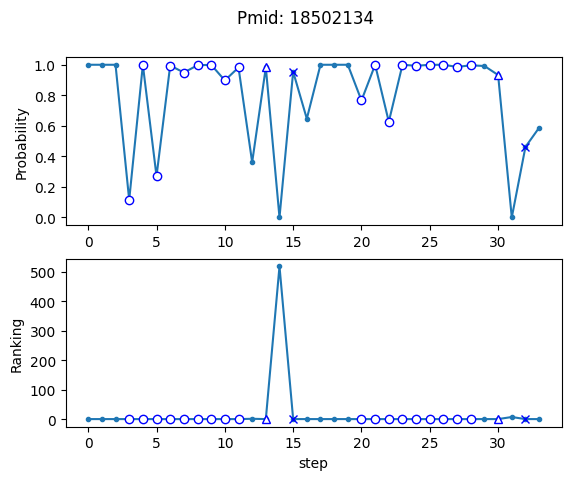

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Create some fake data.
x = np.arange(step)
y1 = prob
y2 = ranking

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle(f'Pmid: {test_data["pmid"]}')

ax1.plot(x, y1, '.-')
ax1.set_ylabel('Probability')

ax2.plot(x, y2, '.-')
ax2.set_xlabel('step')
ax2.set_ylabel('Ranking')

marks = [0]* (step-1)
mark = False

# 0 for  parttern tokens, 1 for drugs ,2 for targets, 3 for interaction
for i, token in enumerate(output_text):
    if token != 6 and output_text[i-1] == 45:
        marks[i] = 1
        mark = True
        continue
    if token == 8 or token == 21 or token == 4:
        continue
    if token != 6 and output_text[i-1] == 8:
        marks[i] = 2
        mark = True
        continue
    if token != 6 and output_text[i-1] == 21:
        marks[i] = 3
        mark = True
        continue
    if token == 44:
        mark = False
        continue
    if mark:
        marks[i] = marks[i-1]
        

# if marks[x] == 1, then using hollow circle for the plot, if marks[x] == 2, then using hollow triangle for the plot, if marks[x] == 3, then using star for the plot.
for i in range(step-1):
    if marks[i] == 1:
        ax1.plot(x[i], y1[i], marker='o', color='white', markeredgecolor='blue')
        ax2.plot(x[i], y2[i], marker='o', color='white', markeredgecolor='blue')
        if y2[i] > 5:
            ax1.plot(x[i], y1[i], marker='o', color='white', markeredgecolor='red')
            ax2.plot(x[i], y2[i], marker='o', color='white', markeredgecolor='red')

    if marks[i] == 2:
        ax1.plot(x[i], y1[i], marker='^', color='white', markeredgecolor='blue')
        ax2.plot(x[i], y2[i], marker='^', color='white', markeredgecolor='blue')
        if y2[i] > 5:
            ax1.plot(x[i], y1[i], marker='^', color='red')
            ax2.plot(x[i], y2[i], marker='^', color='red')

    if marks[i] == 3:
        ax1.plot(x[i], y1[i], marker='x', color='white', markeredgecolor='blue')
        ax2.plot(x[i], y2[i], marker='x', color='white', markeredgecolor='blue')
        if y2[i] > 5:
            ax1.plot(x[i], y1[i], marker='x', color='red')
            ax2.plot(x[i], y2[i], marker='x', color='red')


# plt.savefig(f'analysis/img/{test_data["pmid"]}-*.png')
plt.show()